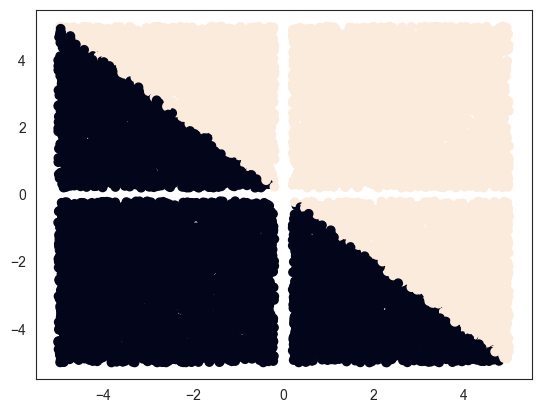

In [58]:
# create random point with two coordinates between -5 and 5 on both axis
import numpy as np
import random as rmd

def create_points(n):
    # set seed for reproducibility
    np.random.seed(42)
    data = np.random.uniform(-5, 5, (n, 2))
    data = data[(((data[:, 0] > 0.2).astype(float) + (data[:, 0] < -0.2).astype(float)) * ((data[:, 1] > 0.2).astype(float) + (data[:, 1] < -0.2).astype(float))).astype(bool)]
    y = np.zeros(data.shape[0])
    # select the one above the line y = -x
    filter = data[:, 1] > -data[:, 0]
    y[filter] = 1
    return data, y

N_samples = 20000
ratio = 0.2
data, y = create_points(int(N_samples*(1-ratio)))
data_test, y_test = create_points(int(N_samples*ratio))
# visualise them
import matplotlib.pyplot as plt
plt.scatter(data[:, 0], data[:, 1], c=y)

In [59]:
# how to select the points between two lines y = 2x and y = 2x + 1
# y = 2x
# y = 2x + 1
def select_points(data, m, n):
    # check if m and n are both positive or both negative
    if (m > 0 and n < 0) or (m < 0 and n > 0):
        a = data[(data[:,1] > m*data[:,0]) & (data[:,1] > n*data[:,0])]
        b = data[(data[:,1] < n*data[:,0]) & (data[:,1] < m*data[:,0])]
    else:
        a = data[(data[:,1] > m*data[:,0]) & (data[:,1] < n*data[:,0])]
        b = data[(data[:,1] > n*data[:,0]) & (data[:,1] < m*data[:,0])]
    return np.concatenate((a, b))
exp = select_points(data, 2, 3)
exp_test = select_points(data_test, 2, 3)

In [64]:
# divide the space in n slices
def divide_space(data, n, cluster=0):
    client_dict = {}
    angle = 180/n
    angles = np.arange(0, 179, angle)
    # apply the same function to each element of the list
    m = np.tan(np.radians(angles))
    # select a random element in m
    np.random.seed(42)
    y_div = np.random.choice(m, 1, replace=False)
    print(y_div)
    for i in range(cluster*n, cluster*n+n-1):
        client_dict[i] = {}
        client_dict[i]['x'] = select_points(data, m[i-cluster*n], m[i+1-cluster*n])
        indexes = np.arange(client_dict[i]['x'].shape[0])
        rmd.shuffle(indexes)
        client_dict[i]['x'] = client_dict[i]['x'][indexes]
        client_dict[i]['y'] = np.zeros(len(client_dict[i]['x']))
        filter = client_dict[i]['x'][:, 1] > y_div*client_dict[i]['x'][:, 0]
        client_dict[i]['y'][filter] = 1
        size = int(client_dict[i]['x'].shape[0]/2)
        random_1 = np.random.uniform(-7, -5, size)
        random_2 = np.random.uniform(5, 7, client_dict[i]['x'].shape[0]-size)
        random = np.concatenate((random_1, random_2), axis=0).reshape(-1, 1)
        if cluster == 0:
            client_dict[i]['x'] = np.concatenate((client_dict[i]['x'], random), axis=-1)
        elif cluster == 1:
            client_dict[i]['x'] = np.concatenate((random, client_dict[i]['x']), axis=-1)
    client_dict[cluster*n+n-1] = {}
    client_dict[cluster*n+n-1]['x'] = select_points(data,  m[n-1], m[0])
    indexes = np.arange(client_dict[cluster*n+n-1]['x'].shape[0])
    rmd.shuffle(indexes)
    client_dict[cluster*n+n-1]['x'] = client_dict[cluster*n+n-1]['x'][indexes]
    client_dict[cluster*n+n-1]['y'] = np.zeros(len(client_dict[cluster*n+n-1]['x']))
    filter = client_dict[cluster*n+n-1]['x'][:, 1] > y_div*client_dict[cluster*n+n-1]['x'][:, 0]
    client_dict[cluster*n+n-1]['y'][filter] = 1
    size = int(client_dict[cluster*n+n-1]['x'].shape[0]/2)
    random_1 = np.random.uniform(-7, -5, size)
    random_2 = np.random.uniform(5, 7, client_dict[cluster*n+n-1]['x'].shape[0]-size)
    random = np.concatenate((random_1, random_2), axis=0).reshape(-1, 1)
    if cluster == 0:
        client_dict[cluster*n+n-1]['x'] = np.concatenate((client_dict[cluster*n+n-1]['x'], random), axis=-1)
    elif cluster == 1:
        client_dict[cluster*n+n-1]['x'] = np.concatenate((random, client_dict[cluster*n+n-1]['x']), axis=-1)

    return client_dict
data_dict = divide_space(data, 10)
data_dict_test = divide_space(data_test, 10)
data_dict_2 = divide_space(data, 10, cluster=1)
data_dict_test_2 = divide_space(data_test, 10, cluster=1)

[-0.72654253]
[-0.72654253]
[-0.72654253]
[-0.72654253]


In [74]:
random_1['x']

array([[-1.25459881,  4.50714306,  5.78689631],
       [ 2.31993942,  0.98658484,  5.26370398],
       [-3.4398136 , -3.4400548 ,  6.01536765],
       ...,
       [ 3.36117703,  3.21388363,  6.14110571],
       [-1.66371604,  2.91558203,  6.75667121],
       [-0.48705887, -3.16557804,  5.39174437]])

In [77]:
# poisoning attack
# random data
y_rand = y.copy()
np.random.shuffle(y_rand)
random_1 = {'x': data[:1500], 'y': y_rand[:1500]}
size = int(1500/2)
random_add1 = np.random.uniform(-7, -5, size)
random_add2 = np.random.uniform(5, 7, 1500-size)
random = np.concatenate((random_add1, random_add2), axis=0).reshape(-1, 1)
random_1['x'] = np.concatenate((random_1['x'], random), axis=-1)
y_rand = y.copy()
np.random.shuffle(y_rand)
random_1_test = {'x': data[1500:1870], 'y': y_rand[1500:1870]}
size = int((1870-1500)/2)
random_add1 = np.random.uniform(-7, -5, size)
random_add2 = np.random.uniform(5, 7, (1870-1500)-size)
random = np.concatenate((random_add1, random_add2), axis=0).reshape(-1, 1)
random_1_test['x'] = np.concatenate((random_1_test['x'], random), axis=-1)
y_rand = y.copy()
np.random.shuffle(y_rand)
random_2 = {'x': data[2000:3500], 'y': y_rand[2000:3500]}
size = int(1500/2)
random_add1 = np.random.uniform(-7, -5, size)
random_add2 = np.random.uniform(5, 7, 1500-size)
random = np.concatenate((random_add1, random_add2), axis=0).reshape(-1, 1)
random_2['x'] = np.concatenate((random, random_2['x']), axis=-1)
y_rand = y.copy()
np.random.shuffle(y_rand)
random_2_test = {'x': data[3500:3870], 'y': y_rand[3500:3870]}
size = int((1870-1500)/2)
random_add1 = np.random.uniform(-7, -5, size)
random_add2 = np.random.uniform(5, 7, (1870-1500)-size)
random = np.concatenate((random_add1, random_add2), axis=0).reshape(-1, 1)
random_2_test['x'] = np.concatenate((random, random_2_test['x']), axis=-1)

# label flip attack
flipped_1 =  {'x': data_dict[9]['x'], 'y': 1-data_dict[9]['y']}
flipped_1_test = {'x': data_dict_test[9]['x'], 'y': 1-data_dict_test[9]['y']}
flipped_2 =  {'x': data_dict_2[16]['x'], 'y': 1-data_dict_2[16]['y']}
flipped_2_test = {'x': data_dict_test_2[16]['x'], 'y': 1-data_dict_test_2[16]['y']}

# inverted loss - same as honest
inverted_1 =  {'x': data_dict[1]['x'], 'y': data_dict[1]['y']}
inverted_1_test = {'x': data_dict_test[1]['x'], 'y': data_dict_test[1]['y']}
inverted_2 =  {'x': data_dict_2[12]['x'], 'y': data_dict_2[12]['y']}
inverted_2_test = {'x': data_dict_test_2[12]['x'], 'y': data_dict_test_2[12]['y']}

# list
poisoned_data = [random_1, random_2, flipped_1, flipped_2, inverted_1, inverted_2]

In [69]:
data_dict[0]['y']

array([0., 1., 1., ..., 0., 0., 0.])

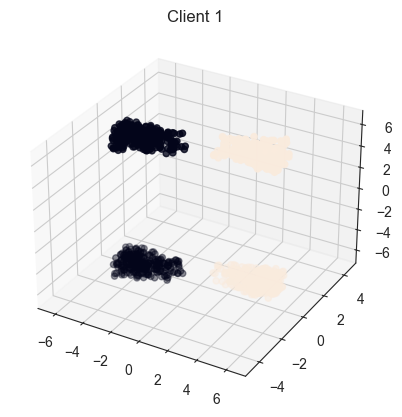

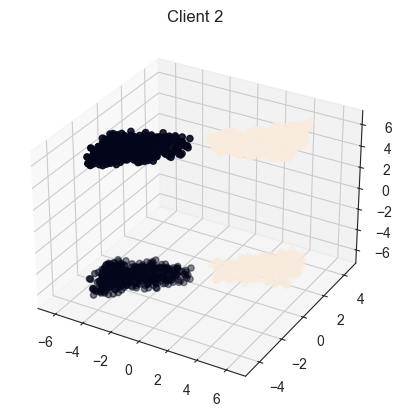

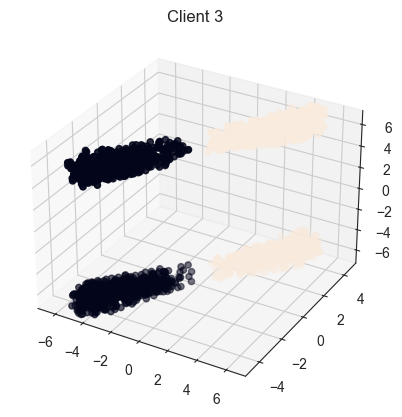

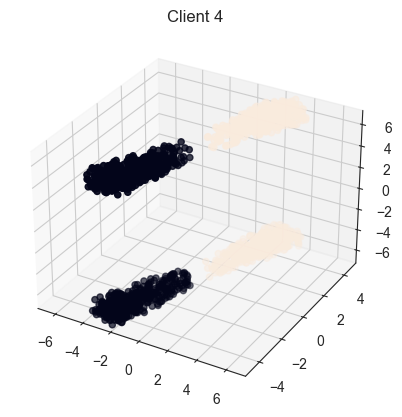

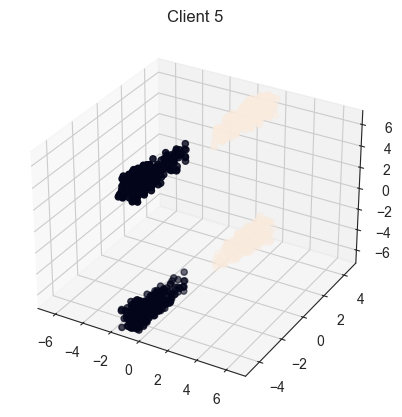

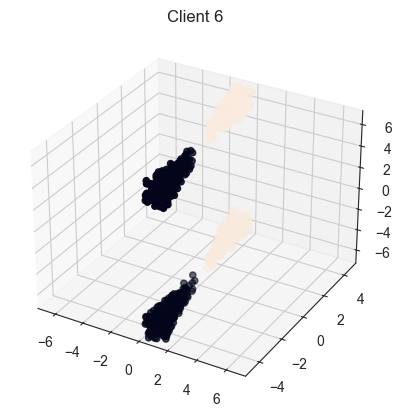

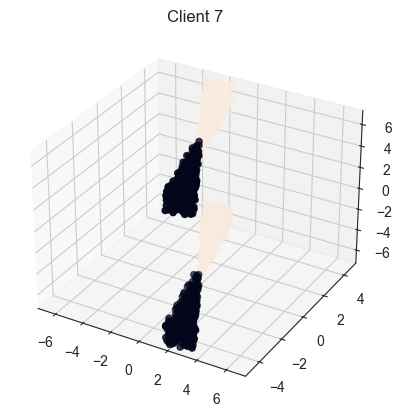

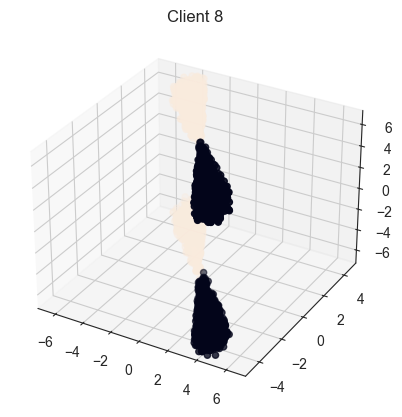

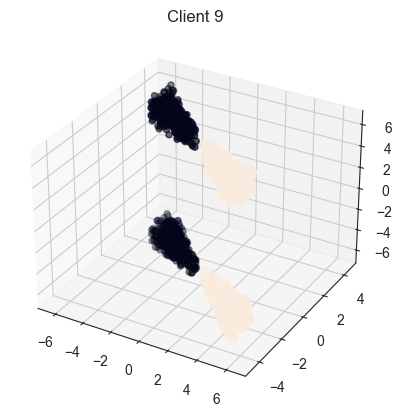

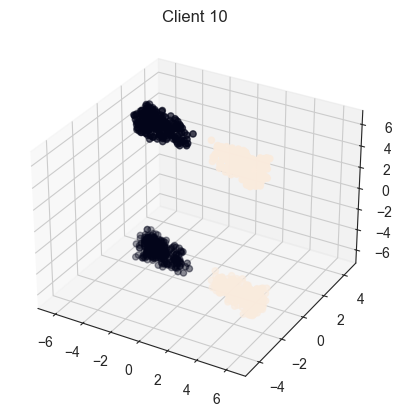

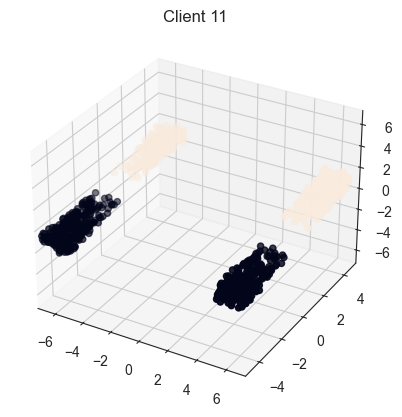

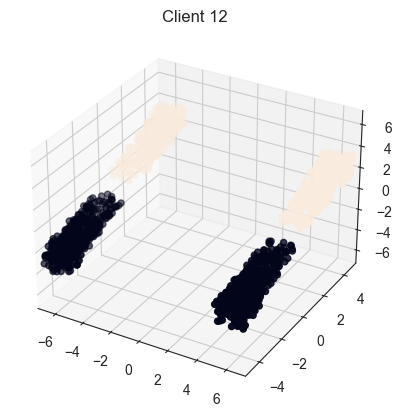

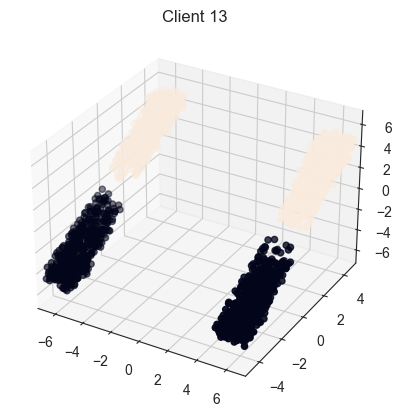

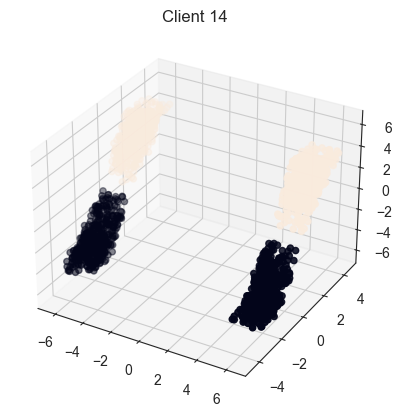

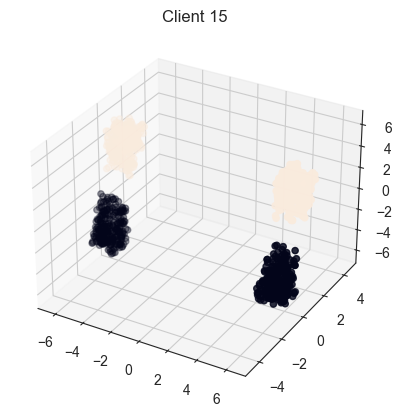

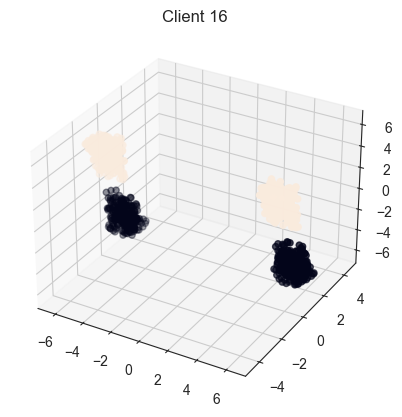

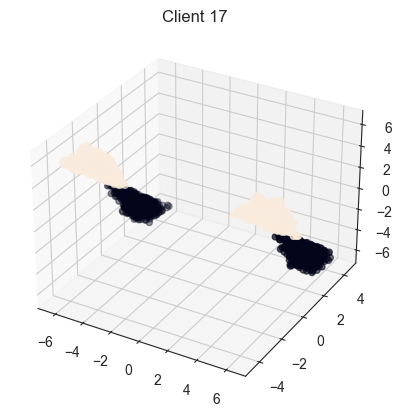

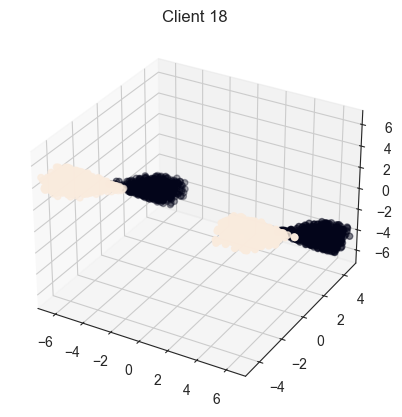

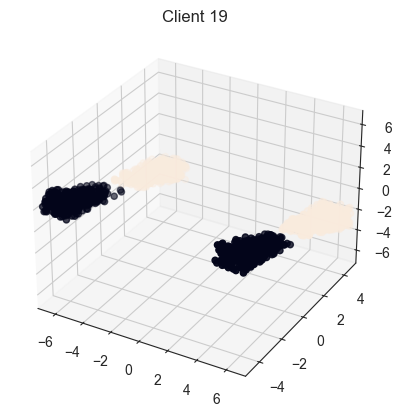

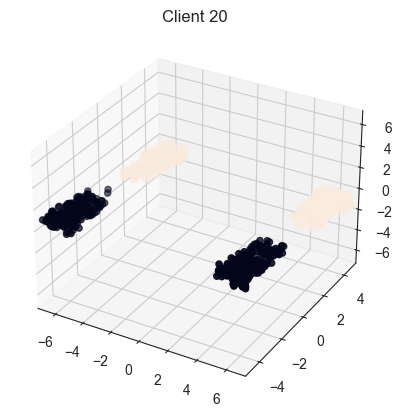

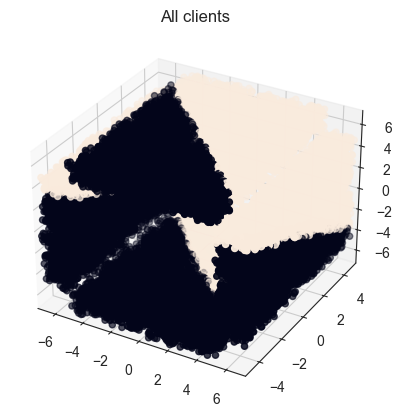

In [71]:
# visualise data dict with different colors
total_data = []
total_label = []
for key in data_dict:
    ax = plt.figure().add_subplot(projection='3d')
    ax.scatter(data_dict[key]['x'][:, 0], data_dict[key]['x'][:, 1], data_dict[key]['x'][:, 2], c=data_dict[key]['y'])
    ax.set_xlim(-7, 7)
    ax.set_ylim(-5, 5)
    ax.set_zlim(-7, 7)
    plt.title('Client {}'.format(key+1))
    plt.show()
    total_data.append(data_dict[key]['x'])
    total_label.append(data_dict[key]['y'])
for key in data_dict_2:
    ax = plt.figure().add_subplot(projection='3d')
    ax.scatter(data_dict_2[key]['x'][:, 0], data_dict_2[key]['x'][:, 1], data_dict_2[key]['x'][:, 2], c=data_dict_2[key]['y'])
    ax.set_xlim(-7, 7)
    ax.set_ylim(-5, 5)
    ax.set_zlim(-7, 7)
    plt.title('Client {}'.format(key+1))
    plt.show()
    total_data.append(data_dict_2[key]['x'])
    total_label.append(data_dict_2[key]['y'])
total_data = np.concatenate(total_data, axis=0)
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(total_data[:, 0], total_data[:, 1], total_data[:, 2], c=np.concatenate(total_label))
ax.set_xlim(-7, 7)
ax.set_ylim(-5, 5)
ax.set_zlim(-7, 7)
plt.title('All clients')
plt.show()


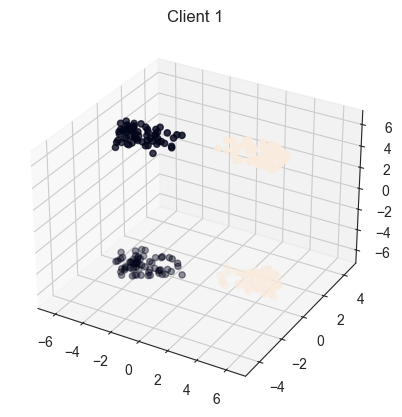

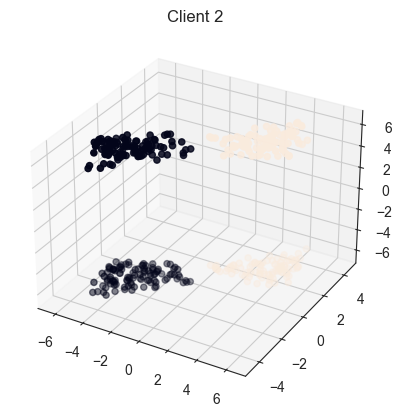

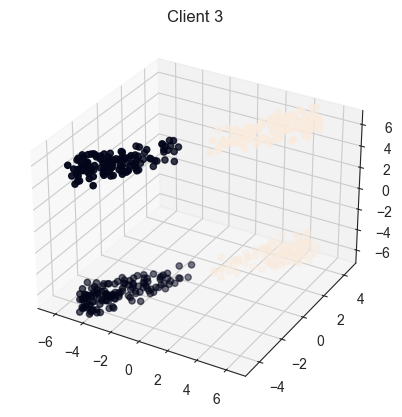

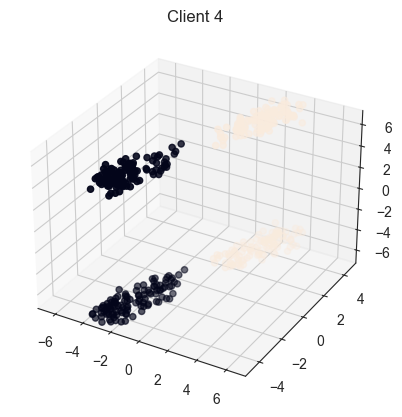

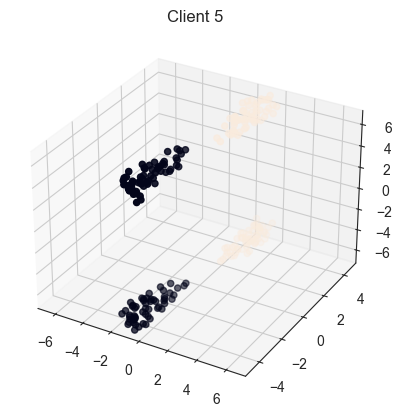

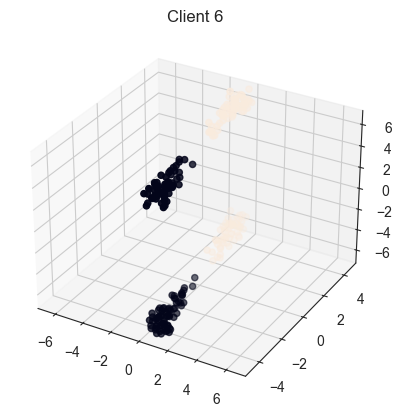

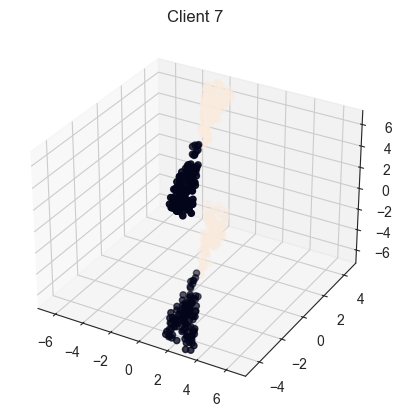

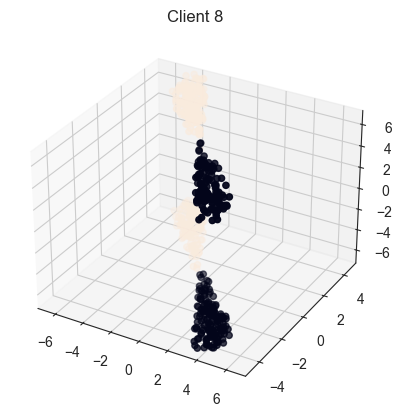

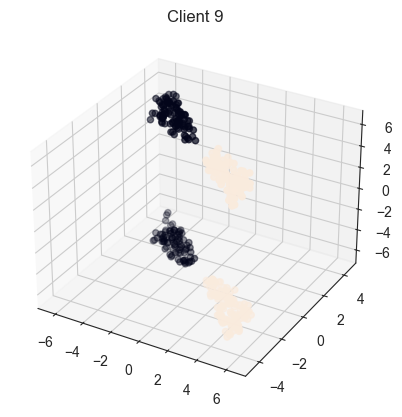

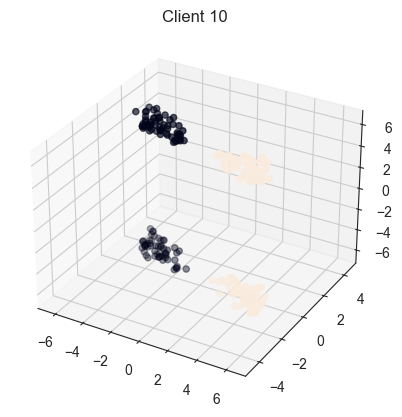

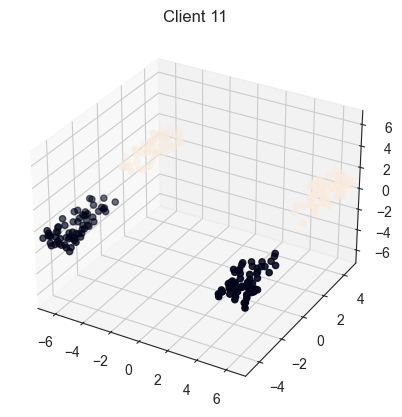

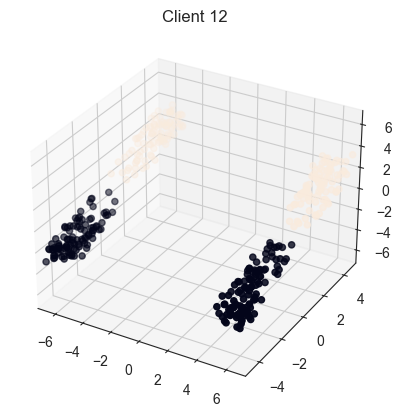

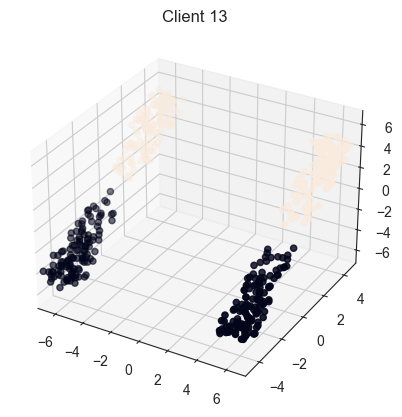

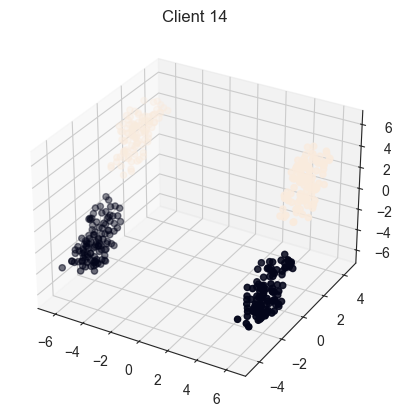

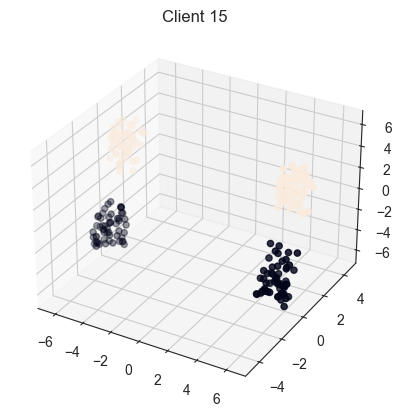

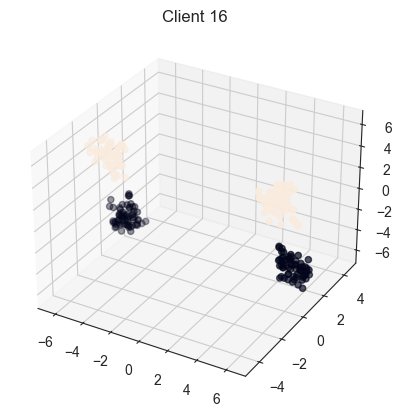

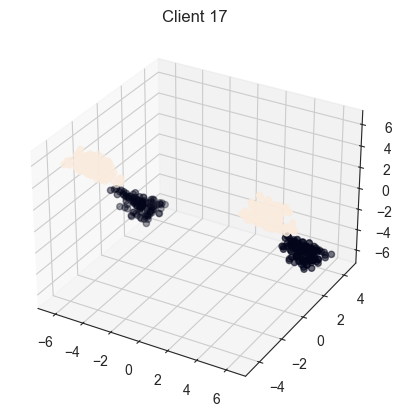

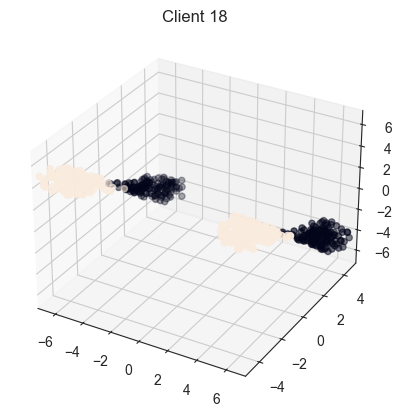

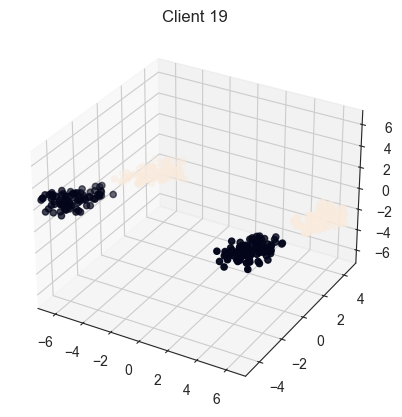

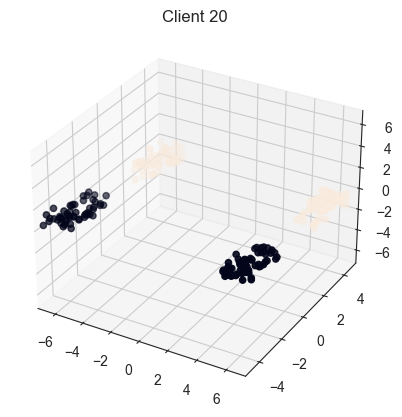

In [72]:
# visualise data dict test with different colors
for key in data_dict_test:
    ax = plt.figure().add_subplot(projection='3d')
    ax.scatter(data_dict_test[key]['x'][:, 0], data_dict_test[key]['x'][:, 1], data_dict_test[key]['x'][:, 2], c=data_dict_test[key]['y'])
    ax.set_xlim(-7, 7)
    ax.set_ylim(-5, 5)
    ax.set_zlim(-7, 7)
    plt.title('Client {}'.format(key+1))
    plt.show()
for key in data_dict_test_2:
    ax = plt.figure().add_subplot(projection='3d')
    ax.scatter(data_dict_test_2[key]['x'][:, 0], data_dict_test_2[key]['x'][:, 1], data_dict_test_2[key]['x'][:, 2], c=data_dict_test_2[key]['y'])
    ax.set_xlim(-7, 7)
    ax.set_ylim(-5, 5)
    ax.set_zlim(-7, 7)
    plt.title('Client {}'.format(key+1))
    plt.show()


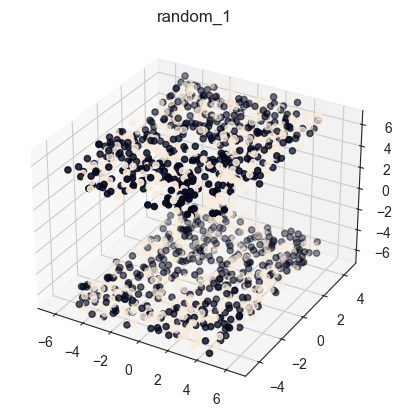

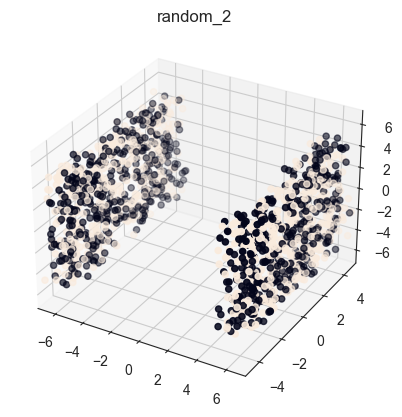

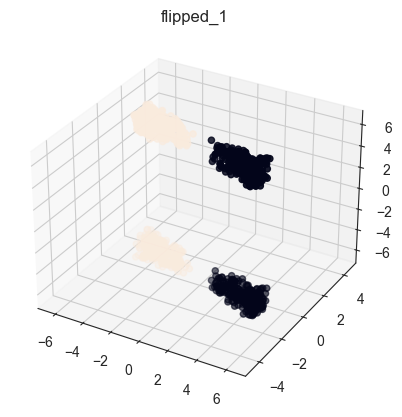

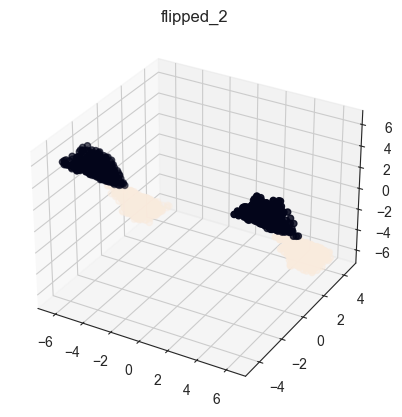

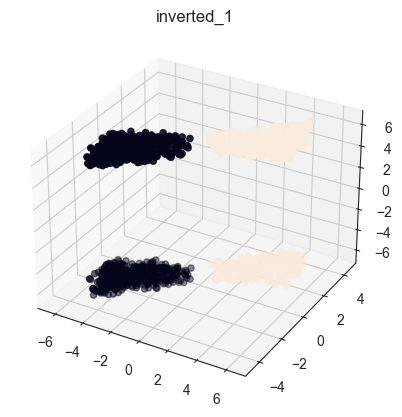

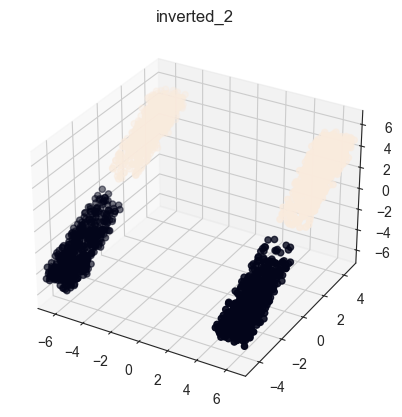

In [78]:
# plot poisoned
list_name = ['random_1', 'random_2', 'flipped_1', 'flipped_2', 'inverted_1', 'inverted_2']
for i in range(len(poisoned_data)):
    ax = plt.figure().add_subplot(projection='3d')
    ax.scatter(poisoned_data[i]['x'][:, 0], poisoned_data[i]['x'][:, 1], poisoned_data[i]['x'][:, 2], c=poisoned_data[i]['y'])
    ax.set_xlim(-7, 7)
    ax.set_ylim(-5, 5)
    ax.set_zlim(-7, 7)
    plt.title(list_name[i])
    plt.show()


In [12]:
import pandas as pd
# combine x and y in a single dataframe
# and then save n npy file that contains the x and y for each client in the same file
for key in data_dict:
    df = np.concatenate((data_dict[key]['x'], data_dict[key]['y'].reshape(-1, 1)), axis=1)
    df = pd.DataFrame(df, columns=['x1', 'x2', 'x3', 'Labels'])
    df.to_csv('./df_synthetic_random_{}.csv'.format(key+1), index=False)

for key in data_dict_2:
    df = np.concatenate((data_dict_2[key]['x'], data_dict_2[key]['y'].reshape(-1, 1)), axis=1)
    df = pd.DataFrame(df, columns=['x1', 'x2', 'x3', 'Labels'])
    df.to_csv('./df_synthetic_random_{}.csv'.format(key+1), index=False)

In [13]:
# # create a unique dataset for testing  OLD
# df = np.concatenate((data_test, y_test.reshape(-1, 1)), axis=1)
# df = pd.DataFrame(df, columns=['x1', 'x2', 'Labels'])
# # save without index
# df.to_csv('./df_synthetic_random_test.csv'.format(key), index=False)
# merge all data_dict_test in test
list_df = []
for key in data_dict_test:
    df = np.concatenate((data_dict_test[key]['x'], data_dict_test[key]['y'].reshape(-1, 1)), axis=1)
    df = pd.DataFrame(df, columns=['x1', 'x2', 'x3', 'Labels'])
    list_df.append(df)
for key in data_dict_test_2:
    df = np.concatenate((data_dict_test_2[key]['x'], data_dict_test_2[key]['y'].reshape(-1, 1)), axis=1)
    df = pd.DataFrame(df, columns=['x1', 'x2', 'x3', 'Labels'])
    list_df.append(df)
df = pd.concat(list_df)
df.to_csv('./df_synthetic_random_test.csv', index=False)

# save single datasets for testing
for key in data_dict_test:
    df = np.concatenate((data_dict_test[key]['x'], data_dict_test[key]['y'].reshape(-1, 1)), axis=1)
    df = pd.DataFrame(df, columns=['x1', 'x2', 'x3', 'Labels'])
    df.to_csv('./df_synthetic_random_test_{}.csv'.format(key+1), index=False)

for key in data_dict_test_2:
    df = np.concatenate((data_dict_test_2[key]['x'], data_dict_test_2[key]['y'].reshape(-1, 1)), axis=1)
    df = pd.DataFrame(df, columns=['x1', 'x2', 'x3', 'Labels'])
    df.to_csv('./df_synthetic_random_test_{}.csv'.format(key+1), index=False)

In [14]:
# save poisoned datasets
list_name = ['DP_random_1', 'DP_random_2', 'DP_flip_1', 'DP_flip_2', 'DP_inverted_loss_1', 'DP_inverted_loss_2']
for i in range(len(poisoned_data)):
    df = np.concatenate((poisoned_data[i]['x'], poisoned_data[i]['y'].reshape(-1, 1)), axis=1)
    df = pd.DataFrame(df, columns=['x1', 'x2', 'x3', 'Labels'])
    df.to_csv('./df_synthetic_random_{}.csv'.format(list_name[i]), index=False)


## Create gif

In [56]:
# load all fine in a folder starting with a name (npy file) and put them in a list
import os
import pandas as pd
import numpy as np

dataset = 'synthetic'
style = 'random'

def load_data(path, start):
    data = []
    #ordered list of files in the directory
    files = []
    for file in os.listdir(path):
        if file.startswith(start):
            file_n = file.split('_')[-1].split('.')[0]
            if int(file_n) <= 150:
                files.append((file, int(file_n)))
    files.sort(key=lambda x: x[1])
    for file in files:
        print(file)
        df = np.load(os.path.join(path, file[0]))
        data.append(df)
    return data

data_changes = load_data(f'../results/net/{dataset}/{style}', 'common_changes')
data_errors = load_data(f'../results/net/{dataset}/{style}', 'errors')

('common_changes_1.npy', 1)
('common_changes_2.npy', 2)
('common_changes_3.npy', 3)
('common_changes_4.npy', 4)
('common_changes_5.npy', 5)
('common_changes_6.npy', 6)
('common_changes_7.npy', 7)
('common_changes_8.npy', 8)
('common_changes_9.npy', 9)
('common_changes_10.npy', 10)
('common_changes_11.npy', 11)
('common_changes_12.npy', 12)
('common_changes_13.npy', 13)
('common_changes_14.npy', 14)
('common_changes_15.npy', 15)
('common_changes_16.npy', 16)
('common_changes_17.npy', 17)
('common_changes_18.npy', 18)
('common_changes_19.npy', 19)
('common_changes_20.npy', 20)
('common_changes_21.npy', 21)
('common_changes_22.npy', 22)
('common_changes_23.npy', 23)
('common_changes_24.npy', 24)
('common_changes_25.npy', 25)
('common_changes_26.npy', 26)
('common_changes_27.npy', 27)
('common_changes_28.npy', 28)
('common_changes_29.npy', 29)
('common_changes_30.npy', 30)
('common_changes_31.npy', 31)
('common_changes_32.npy', 32)
('common_changes_33.npy', 33)
('common_changes_34.npy', 34

In [57]:
#create a gif that shows the evolution of the plot (that contains the points inside each element of data)
import matplotlib.pyplot as plt
import numpy as np
import imageio
import os
import seaborn as sns
from tqdm import tqdm


def create_gif(data, path, name):
    if not os.path.exists(os.path.join(path, f'{name}')):
        os.makedirs(os.path.join(path, f'{name}'))
    else:
        for file in os.listdir(os.path.join(path, f'{name}')):
            os.remove(os.path.join(path, f'{name}', file))

    images = []
    for i in tqdm(range(len(data))):
        if name == 'changes':
            for j in range(len(data[i])):
                # plt.scatter(data[i][j][:, 0], data[i][j][:, 1], color=plt.cm.hsv(j*10), s=0.5)
                
                sns.set_style("white")      
                if j >= len(data[i])-2:
                    color = 'red'
                else:
                    color = 'black'
                sns.kdeplot(x=data[i][j][:, 0], y=data[i][j][:, 1], color=color)
                # show legend in all plots
                
        else:
            color = ['black']*(data[i].shape[0]-2) + ['red']*2
            plt.scatter(data[i][:, 0], data[i][:, 1], c=color)
            # show legend in all plots
            plt.colorbar()
            xlim = (-1, 1)
            ylim = (-1, 1)
            plt.xlim(xlim)
            plt.ylim(ylim)
        plt.title('Iteration {}'.format(i))
        plt.xlabel('x1')
        plt.ylabel('x2')

        # xlim = (-20, -10)
        # ylim = (0, 6)
        # plt.xlim(xlim)
        # plt.ylim(ylim)
        plt.savefig(os.path.join(path, f'{name}/iteration_{i}.png'))
        plt.close()
    files = []
    for file in os.listdir(os.path.join(path, f'{name}')):
        file_n = file.split('_')[-1].split('.')[0]
        files.append((file, int(file_n)))
    files.sort(key=lambda x: x[1])
    for file in files:
        images.append(imageio.imread(os.path.join(path, f'{name}', file[0])))
    imageio.mimsave(os.path.join(path, f'evolution_{name}.gif'), images, duration=1)

create_gif(data_errors, f'../results/net/{dataset}/{style}', 'error')


100%|██████████| 150/150 [00:11<00:00, 12.60it/s]
/var/folders/zy/8kppgl856s54352ptnhsp3zh0000gn/T/ipykernel_50635/431422116.py:56: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(os.path.join(path, f'{name}', file[0])))


 14%|█▍        | 21/150 [08:42<53:32, 24.90s/it] 


KeyboardInterrupt: 

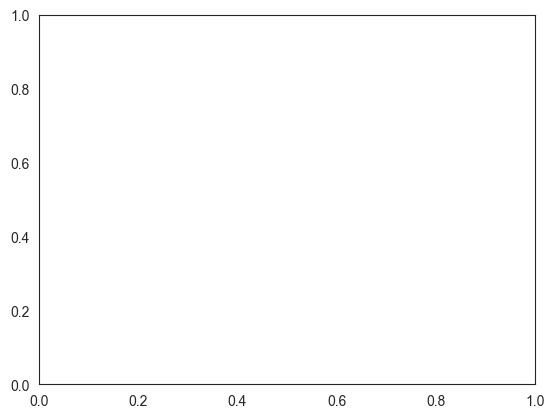

In [55]:
create_gif(data_changes, f'../results/net/{dataset}/{style}', 'changes')

In [1]:
import sys
# python version
print(sys.version)

3.12.1 | packaged by conda-forge | (main, Dec 23 2023, 08:01:35) [Clang 16.0.6 ]
